In [1]:
from collections import defaultdict, Counter
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from Bio import SeqIO
from statannotations.Annotator import Annotator
import json
import itertools

In [2]:
import matplotlib
from pathlib import Path
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

In [4]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from file_configs import MergedFilesConfig
from hyperparams import DefaultParams as Params
from data_loading import one_hot_encode
sys.path.append(f"{PROJECT_DIR_s}6_call_motifs/")
from call_motifs_script import load_coords

# In-silico deletion

## Data preparation

In [5]:
s = "HCT116"
model_type = "strand_merged_umap"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
types = ["wt", "mt"]
merged_config = MergedFilesConfig(s, model_type, f"{PROJECT_DIR_o}procapnet/")
peak_path = merged_config.all_peak_path

In [6]:
params = Params()
in_window = params.in_window
coords = load_coords(peak_path, in_window=in_window)

In [7]:
inputfile = f"{PROJECT_DIR_o}procapnet/motifs_out/{s}/{model_type}/merged/mapping.json"
with open(inputfile, "r") as f:
	mapping = json.load(f)

In [8]:
counts_hits_path = f"{PROJECT_DIR_o}procapnet/motifs_out/{s}/{model_type}/merged/counts_hits.bed"
df_motifs = pd.read_table(counts_hits_path, header=None)
df_motifs.head(2)

0       1       2     3  4  5   6
0  chr1  605487  605497  NRF1  1  +   5
1  chr1  629619  629625  TATA  2  -  10

In [9]:
motifs = list(set(df_motifs[3]))

## Get sequences

In [10]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [11]:
def get_sequences(motif, outputfile, coords, fdict, t):
	seqs = []
	df = df_motifs[(df_motifs[3]==motif) & (df_motifs[4].astype(str).isin(mapping))]
	for index, row in df.iterrows():
		chrom, start, end = coords[row[4]]
		seq = fdict[chrom][int(start):int(end)].seq.upper()
		wt_seq = one_hot_encode(seq)
		if t == "wt":
			seqs.append(wt_seq.T)
		else:
			mut_start, mut_end = row[1], row[2]
			# replace motif with [0,0,0,0]
			mt_seq = wt_seq
			for i in range(mut_start-start, mut_end-start):
				mt_seq[i] = [0,0,0,0]
			seqs.append(mt_seq.T)
	seqs = np.array(seqs)
	np.save(outputfile, seqs)

In [12]:
for motif, t in itertools.product(motifs, types):
	outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_modisco_{motif}_{t}.npy"
	get_sequences(motif, outputfile, coords, fdict, t)

## Prediction

In [16]:
# add gpu 

script = f"{PROJECT_DIR_s}slurm/predict.sh"
scale = "True"
model_type = "strand_merged_umap"
for motif, t in itertools.product(motifs, types):
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_modisco_{motif}_{t}.npy"
	output_prefix = f"{PROJECT_DIR_o}procapnet/prediction/{s}_modisco_{motif}_{t}."
	commands = ["sbatch", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				output_prefix,
				scale,
				str(types.index(t))
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_modisco_ZBTB33_wt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_modisco_ZBTB33_wt. True 0
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_modisco_ZBTB33_mt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_modisco_ZBTB33_mt. True 1
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/proc

# Changes vs. position

## Position-dependent changes

In [17]:
pred_profs = {}
for motif, t in itertools.product(motifs, types):
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_modisco_{motif}_{t}.scaled_profiles.npy"
	pred_profs[(motif,t)] = np.load(inputfile)

In [18]:
n_motifs = {}
for motif in motifs:
	n_motifs[motif] = pred_profs[(motif,t)].shape[0]

In [19]:
# Get log2FC for each strand

FCs = defaultdict(list)
for motif in motifs:
	for n in range(n_motifs[motif]):
		fwd = []
		rev = []
		for t in types:
			fwd.append(sum(pred_profs[(motif,t)][n][0]))
			rev.append(sum(pred_profs[(motif,t)][n][1]))
		# wt/mt
		FCs[motif].append((fwd[1]/fwd[0], rev[1]/rev[0]))

In [20]:
results = []
bin_size = 10
for motif in motifs:
	df = df_motifs[(df_motifs[3]==motif) & (df_motifs[4].astype(str).isin(mapping))].reset_index(drop=True)
	for index, row in df.iterrows():
		chrom, tss1, tss2, sign = mapping[str(row[4])][:-2]
		motif_start, motif_end = row[1:3]
		motif_center = (motif_end + motif_start)//2
		# divergent
		if tss2 != ".":
			revTSS, fwdTSS = tss1, tss2
		# unidirectional
		else:
			if sign == "+":
				fwdTSS, revTSS = tss1, np.nan
			else:
				fwdTSS, revTSS = np.nan, tss1

		fwdFC, revFC = FCs[motif][index]

		if not np.isnan(fwdTSS):
			fwdD = motif_center - fwdTSS
			label = "maxTSS" if sign == "+" else "minTSS"
			results.append([motif, fwdFC, fwdD//bin_size, label])

		if not np.isnan(revTSS):
			revD = revTSS - motif_center
			label = "minTSS" if sign == "+" else "maxTSS"
			results.append([motif, revFC, revD//bin_size, label])				
df_fc = pd.DataFrame(results, columns=["motif", "FC", "bin", "TSS_type"])
# Divide motifs into two categories: upstream and downstream of TSSs
df_fc["pos"] = df_fc["bin"].apply(lambda x: "Downstream of TSS" if x >= 0 else "Upstream of TSS")
df_fc.head(2)

motif        FC  bin TSS_type              pos
0  ZBTB33  0.890253   -1   maxTSS  Upstream of TSS
1  ZBTB33  0.735905  -30   minTSS  Upstream of TSS

In [21]:
df = df_fc[((df_fc["TSS_type"]=="maxTSS") & (df_fc["pos"]=="Upstream of TSS")) | ((df_fc["TSS_type"]=="minTSS") & (df_fc["pos"]=="Downstream of TSS"))]
for motif in motifs:
	print(motif, Counter(df[df["motif"]==motif]["pos"]))

ZBTB33 Counter({'Upstream of TSS': 139, 'Downstream of TSS': 34})
CTCF Counter({'Upstream of TSS': 579, 'Downstream of TSS': 57})
CREB Counter({'Upstream of TSS': 819, 'Downstream of TSS': 275})
SP Counter({'Upstream of TSS': 5928, 'Downstream of TSS': 1511})
NRF1 Counter({'Upstream of TSS': 1044, 'Downstream of TSS': 314})
TATA Counter({'Upstream of TSS': 728, 'Downstream of TSS': 399})
ZNF143 Counter({'Upstream of TSS': 127, 'Downstream of TSS': 22})
NFY Counter({'Upstream of TSS': 2354, 'Downstream of TSS': 642})
YY1 Counter({'Upstream of TSS': 65, 'Downstream of TSS': 23})
AP1 Counter({'Upstream of TSS': 4540, 'Downstream of TSS': 735})
ETS Counter({'Upstream of TSS': 2521, 'Downstream of TSS': 942})


In [22]:
order = ["CTCF", "AP1", "SP", "NFY", "CREB", "NRF1", "ETS"]

In [23]:
def plot_FC(tss_type, order, outputfile):
	fig, ax = plt.subplots(figsize=(5.5,2.8))
	df = df_fc[((df_fc["TSS_type"]=="maxTSS") & (df_fc["pos"]=="Upstream of TSS")) | ((df_fc["TSS_type"]=="minTSS") & (df_fc["pos"]=="Downstream of TSS"))]
	hue_plot_params = {"data": df,
						"x": "motif",
						"y": "FC",
						"hue": "pos",
						"hue_order": ["Downstream of TSS", "Upstream of TSS"],
						"order": order,
						"palette": ["#FFD700", "#b3de69"],
					    "showfliers": False
						}
	g = sns.boxplot(ax=ax, **hue_plot_params)
	g.spines[["right", "top"]].set_visible(False)
	g.axhline(y=1, ls="--", c="#636363")
	legend = g.legend(loc="upper right", bbox_to_anchor=(0.9,1), ncol=2, fontsize=sfontsize)

	g.set_ylabel("FC (mt/wt)", fontsize=bfontsize, fontweight="bold")
	g.tick_params(axis="y", labelsize=sfontsize)
	g.set_ylim([0,2.2])
	g.set_yticks([0,0.5,1,1.5,2])
	
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
	for label in g.get_xticklabels():
		label.set_fontweight("bold")
		label.set_ha("right")
	
	pairs = [[(motif, "Upstream of TSS"), (motif, "Downstream of TSS")] for motif in order]
	annotator = Annotator(g, pairs, **hue_plot_params)
	annotator.configure(test='Mann-Whitney', text_format="star", 
						comparisons_correction="BH",
						verbose=False, text_offset=1, fontsize=sfontsize)
	annotator.apply_and_annotate()

	plt.savefig(outputfile, bbox_inches="tight", dpi=300) 

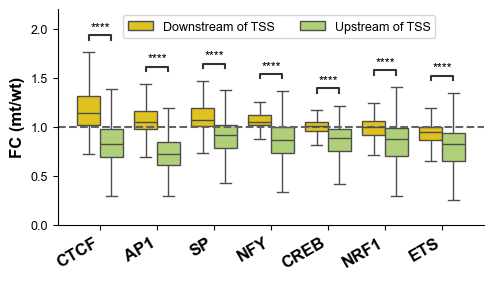

In [24]:
# Downstream of minTSS, Upstream of maxTSS

outputfile = f"{PROJECT_DIR_o}figures/Fig5b.pdf"
plot_FC("", order, outputfile)